### **Model simulation**

In [0]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
random.seed(2020)
from scipy.stats import norm

% likes topic 0 : 70.0
% likes topic 1 : 18.0
% likes topic 2 : 12.0


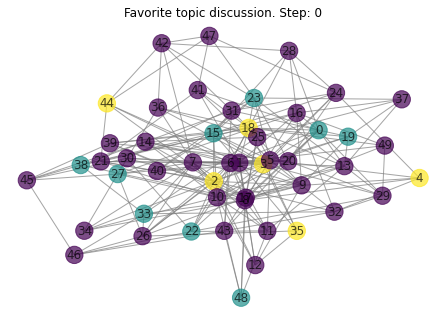

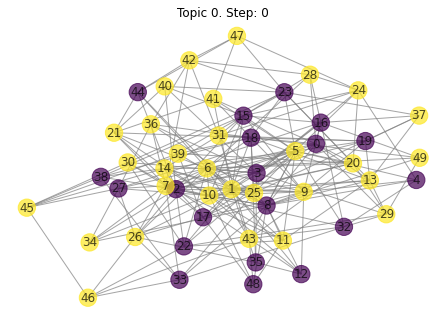

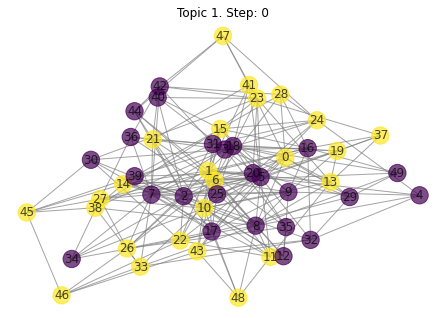

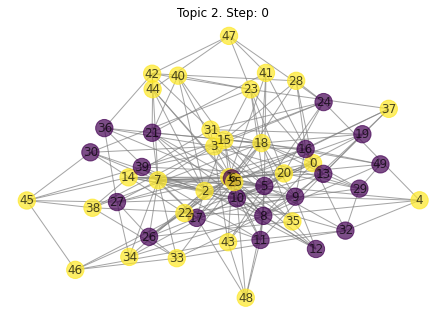

% likes topic 0 : 24.0
% likes topic 1 : 18.0
% likes topic 2 : 57.99999999999999


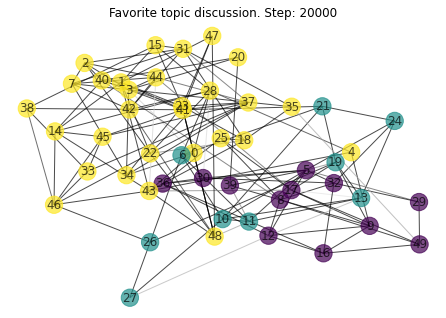

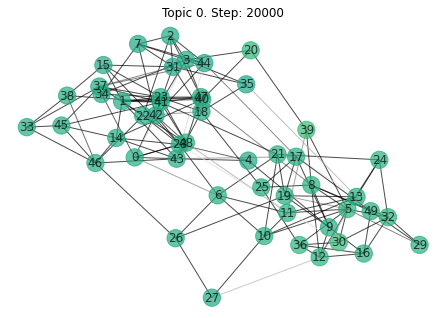

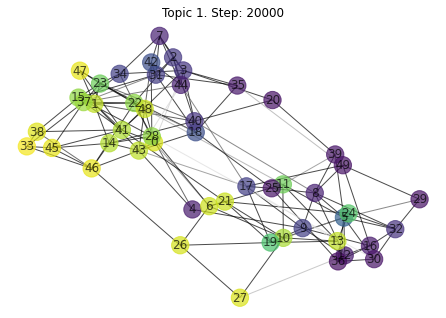

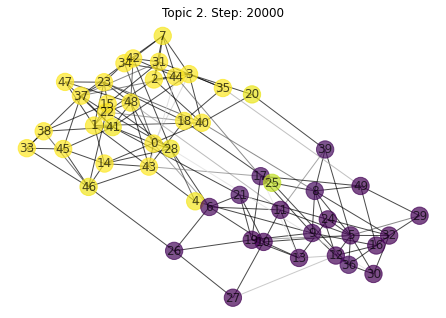

% likes topic 0 : 26.0
% likes topic 1 : 16.0
% likes topic 2 : 57.99999999999999


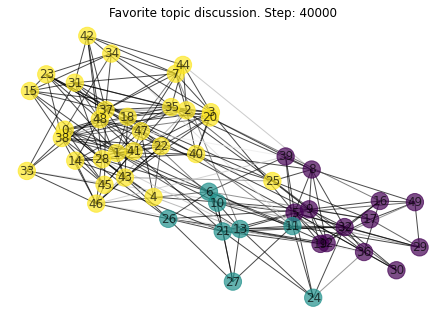

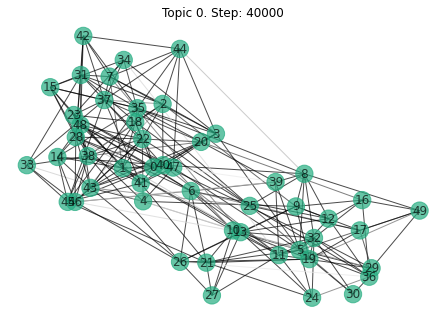

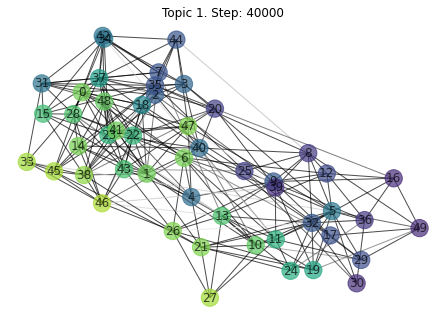

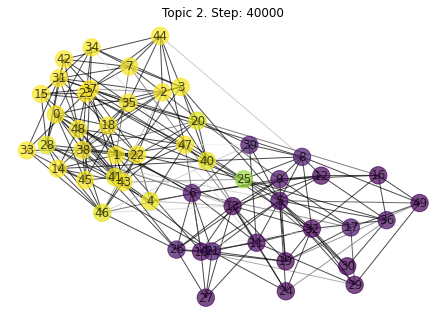

% likes topic 0 : 36.0
% likes topic 1 : 6.0
% likes topic 2 : 57.99999999999999


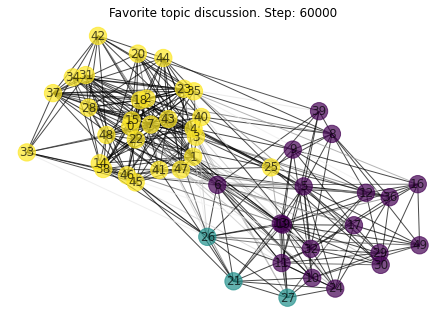

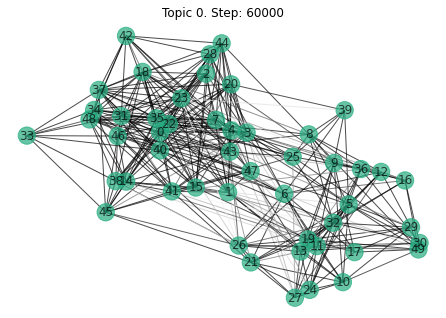

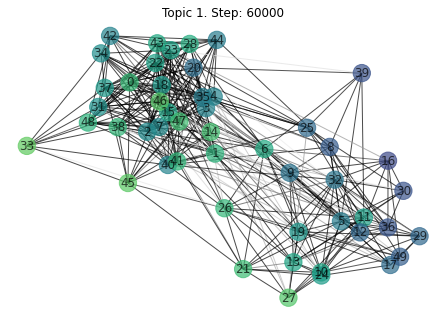

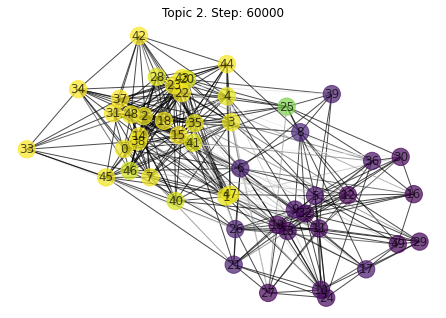

% likes topic 0 : 42.0
% likes topic 1 : 0.0
% likes topic 2 : 57.99999999999999


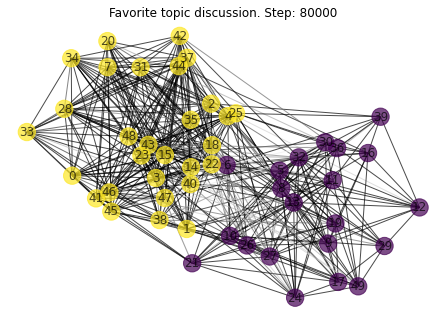

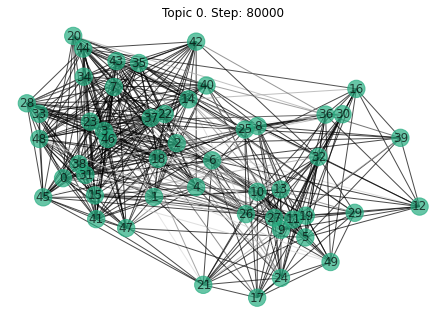

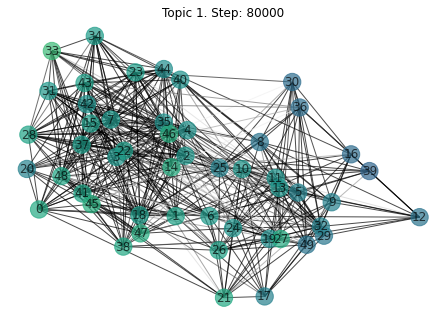

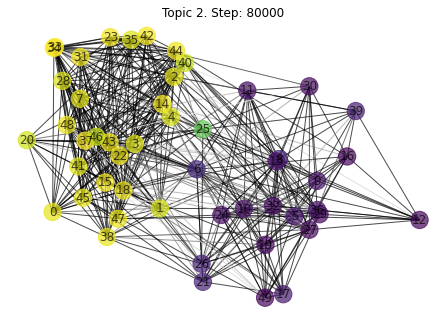

% likes topic 0 : 42.0
% likes topic 1 : 0.0
% likes topic 2 : 57.99999999999999


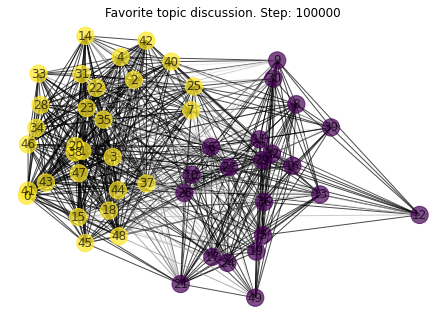

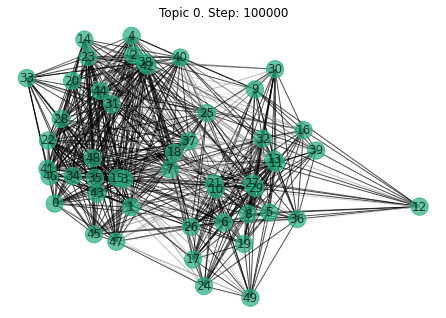

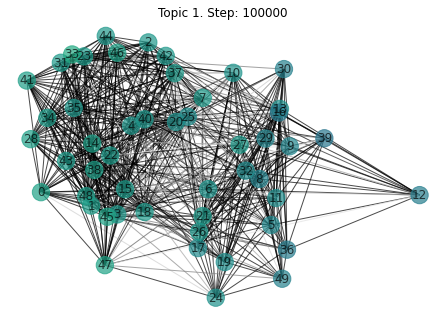

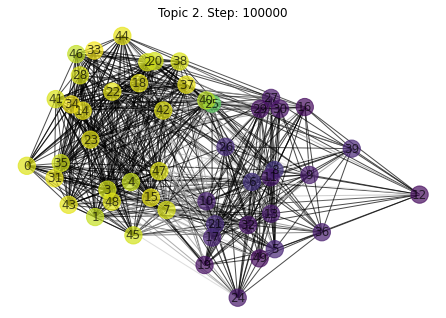

In [2]:


class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.05, beta=0.3, gamma=4, alpha_std = 0.01, beta_std=0.05, gamma_std=1, num_opinion = 3):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.05. This has a standard deviation: alpha_std. Default: 0.01

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.
               This has a standard deviation: abeta_std. Default: 0.05

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
               This has a standard deviation: alpha_std. Default: 1

            num_opinion: number of opinions (integer)
            
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.alpha_std = alpha_std
        self.beta_std = beta_std
        self.gamma_std = gamma_std
        self.num_opinion = num_opinion

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.barabasi_albert_graph(50, 5, 2020)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
            # generate random values from a normal distribution
            self.graph.edges[edge]['beta'] = norm.rvs(self.beta, self.beta_std, size = 1)[0]
            self.graph.edges[edge]['gamma'] = norm.rvs(self.gamma, self.gamma_std, size = 1)[0]
        for node in self.graph.nodes:
            # an array of opinion values
            self.graph.nodes[node]['opinion'] = [random.randint(0, 1) for _ in range(self.num_opinion)]
            # generate random values from a normal distribution
            self.graph.nodes[node]['alpha'] = norm.rvs(self.alpha, self.alpha_std, size = self.num_opinion)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe_fav_topic(self):
        '''
        Draw the state of the network with which topic each node is most prefer
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        # all the nodes and get the max opinion
        master_list = np.array([list(self.graph.nodes[i]['opinion']).index(max(self.graph.nodes[i]['opinion'])) for i in self.graph.nodes])
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color = master_list,
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=self.num_opinion - 1)
        plt.title('Favorite topic discussion. Step: ' + str(self.step))
        
        # print the percentage preference
        for i in range(self.num_opinion):
          print("% likes topic", i, ":", np.mean(master_list == i)*100)
        plt.show()

    def observe_topic(self, topic):
        '''
        Draw the state of the network for each topic
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            # get the topic value for each node
            node_color=[self.graph.nodes[i]['opinion'][topic] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Topic ' + str(topic) +  '. Step: ' + str(self.step))
        plt.show()

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with 1-sigmoid(opinion difference in selected topic)
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            opinions = [self.graph.nodes[n]['opinion'] for n in new_edge]

            # choose random topic
            topic = random.randint(0, self.num_opinion - 1)
            new_weight = abs(np.array(opinions[0]) - np.array(opinions[1]))[topic]
            new_weight = 1 - (1/(1 + np.exp(-new_weight)))
            self.graph.add_edge(new_edge[0], new_edge[1], weight = new_weight, 
                                beta = norm.rvs(self.beta, self.beta_std, size = 1)[0], 
                                gamma = norm.rvs(self.gamma, self.gamma_std, size = 1)[0])
            
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            # select topic
            topic = random.randint(0, self.num_opinion - 1)
            # conservativeness of the topic
            topic_pref = 10**(-topic)
            for i in [0, 1]:
                # update the node with the topic_preference value
                self.graph.nodes[edge[i]]['opinion'][topic] = (
                    opinions[i][topic] + topic_pref * self.graph.nodes[edge[i]]['alpha'][topic] * weight * (opinions[1-i][topic] - opinions[i][topic]))
            
            self.graph.edges[edge]['weight'] = (
                weight +
                self.graph.edges[edge]['beta'] * weight * (1-weight) *
                (1 - self.graph.edges[edge]['gamma'] * abs(opinions[0][topic] - opinions[1][topic])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

    def concensus(self):
      '''
      Calculate the polarization value:
      the polarization is the difference between the mean of people having the opinion > 0.5 
      and of those having an opinion < 0.5. 
      '''
      opinions = np.array([self.graph.nodes[i]['opinion'] for i in self.graph.nodes])
      opinions = opinions.T
      polarize = [np.mean(opinions[i][opinions[i] >= 0.5]) - np.mean(opinions[i][opinions[i] < 0.5]) for i in range(self.num_opinion)]
      if str(polarize[0]) == "nan":
        polarize[0] = np.mean(opinions[0])
      if str(polarize[1]) == "nan":
        polarize[1] = np.mean(opinions[1])
      if str(polarize[2]) == "nan":
        polarize[2] = np.mean(opinions[2])
      return polarize

    def topic_concensus(self):
      '''
      Calculate the percentage of people have strong preference on each topic
      '''
      master_list = np.array([list(self.graph.nodes[i]['opinion']).index(max(self.graph.nodes[i]['opinion'])) for i in self.graph.nodes])
      return [np.mean(master_list == i)*100 for i in range(self.num_opinion)]

    def num_weight(self):
      '''
      Number of conenctions
      '''
      master_list = [self.graph.edges[i, j]['weight'] for i, j in self.graph.edges]
      return len(master_list)
    
    def avg_weight(self):
      ''' 
      Average connection weights
      '''
      master_list = [self.graph.edges[i, j]['weight'] for i, j in self.graph.edges]
      return np.mean(master_list)

    def get_num_opinion(self):
      '''
      get number of opinion
      '''
      return self.num_opinion


# simulate
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe_fav_topic()
for j in range(sim.get_num_opinion()):
  sim.observe_topic(j)

for i in range(5):
    for k in range(20000):
        sim.update()
    plt.figure()
    sim.observe_fav_topic()
    for j in range(sim.get_num_opinion()):
      sim.observe_topic(j)


% likes topic 0 : 68.0
% likes topic 1 : 22.0
% likes topic 2 : 10.0


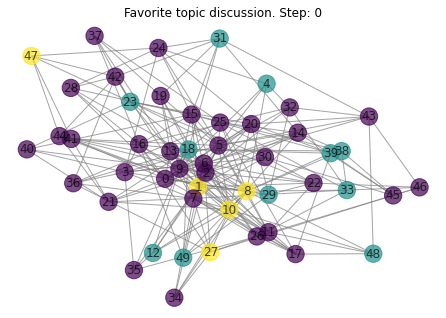

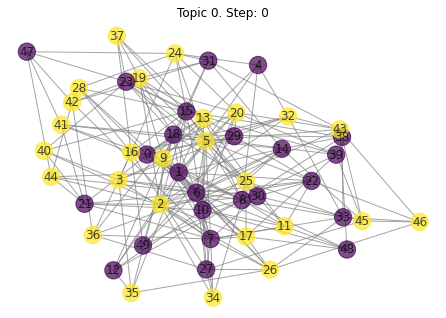

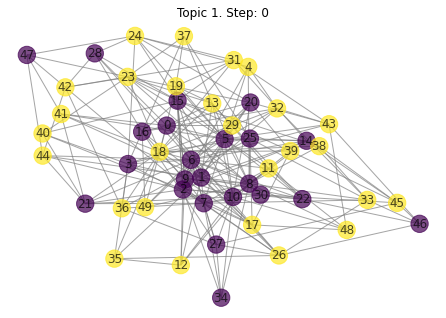

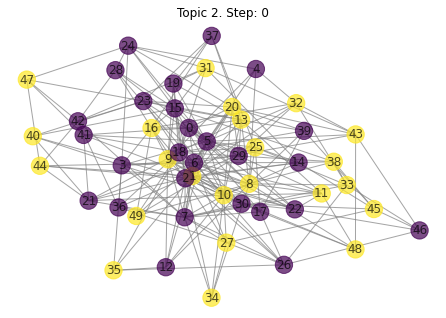

0
1


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2
3
4


In [3]:
# simulate and track variables
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe_fav_topic()
for j in range(sim.get_num_opinion()):
  sim.observe_topic(j)

# track all the metrics
track_concensus = [sim.concensus()]
track_topic = [sim.topic_concensus()]
track_num_weight = [sim.num_weight()]
track_avg_weight = [sim.avg_weight()]

for i in range(5):
    print(i)
    for k in range(30000):
        sim.update()
        if (k+1)%3000 == 0:
          track_concensus.append(sim.concensus())
          track_topic.append(sim.topic_concensus())
          track_num_weight.append(sim.num_weight())
          track_avg_weight.append(sim.avg_weight())

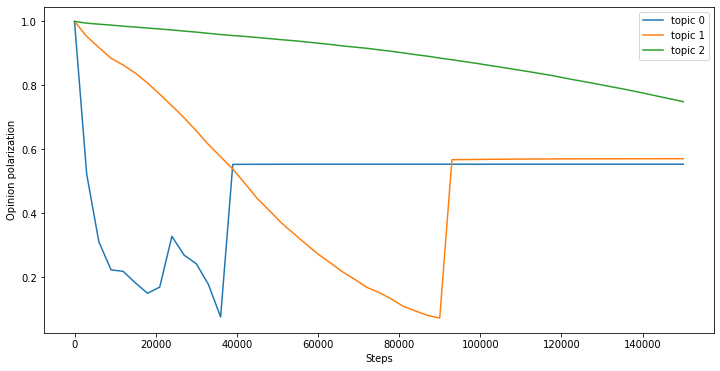

In [4]:
# visualize the result

plt.figure(figsize = (12, 6))
for i in range(sim.get_num_opinion()):
  plt.plot(np.array(range(len(np.array(track_concensus).T[0])))*3000, np.array(track_concensus).T[i], label = "topic " + str(i))
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Opinion polarization")
plt.show()

### **Model simulation for multiple trials**

In [5]:
# simulate the whole code
num_trial = 30
# track results over trials
total_concensus = []
total_topic = []
total_num_weight = []
total_avg_weight = []
for i in range(num_trial):
  sim = SocialDynamicsSimulation()
  sim.initialize()

  track_concensus = [sim.concensus()]
  track_topic = [sim.topic_concensus()]
  track_num_weight = [sim.num_weight()]
  track_avg_weight = [sim.avg_weight()]

  for i in range(5):
      for k in range(20000):
          sim.update()
          if (k+1)%1000 == 0:
            # track every 1000 steps
            track_concensus.append(sim.concensus())
            track_topic.append(sim.topic_concensus())
            track_num_weight.append(sim.num_weight())
            track_avg_weight.append(sim.avg_weight())
  total_concensus.append(track_concensus)
  total_topic.append(track_topic)
  total_num_weight.append(track_num_weight)
  total_avg_weight.append(track_avg_weight)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
# get the mean of the trials
final_concensus = np.mean(np.array(total_concensus), axis = 0)
final_topic = np.mean(np.array(total_topic), axis = 0)
final_num_weight = np.mean(total_num_weight, axis = 0)
final_avg_weight = np.mean(total_avg_weight, axis = 0)

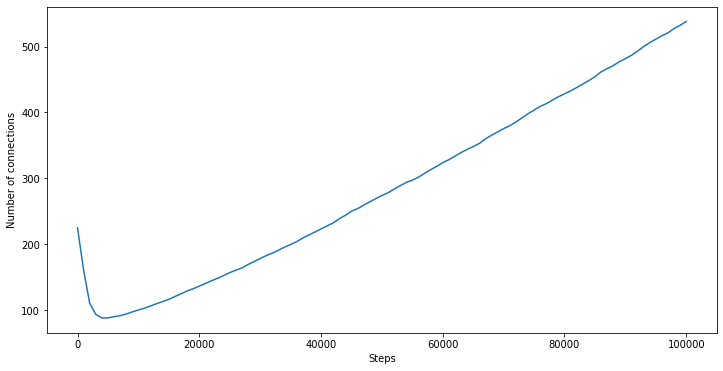

In [7]:
# visualize the number of connections
plt.figure(figsize = (12, 6))
plt.plot(np.array(range(len(final_num_weight)))*1000, final_num_weight)
plt.xlabel("Steps")
plt.ylabel("Number of connections")
plt.show()

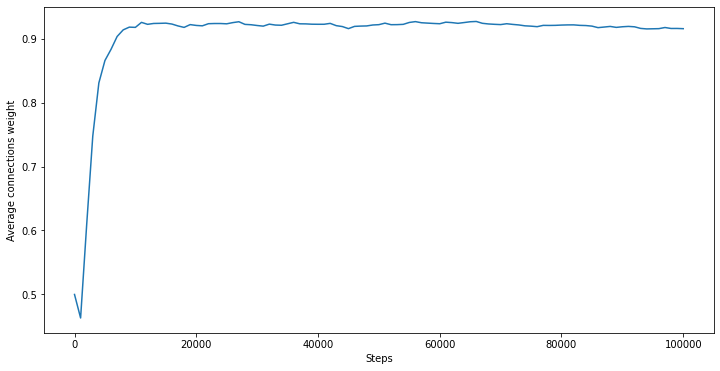

In [8]:
# visulize the average weight
plt.figure(figsize = (12, 6))
plt.plot(np.array(range(len(final_avg_weight)))*1000, final_avg_weight)
plt.xlabel("Steps")
plt.ylabel("Average connections weight")
plt.show()

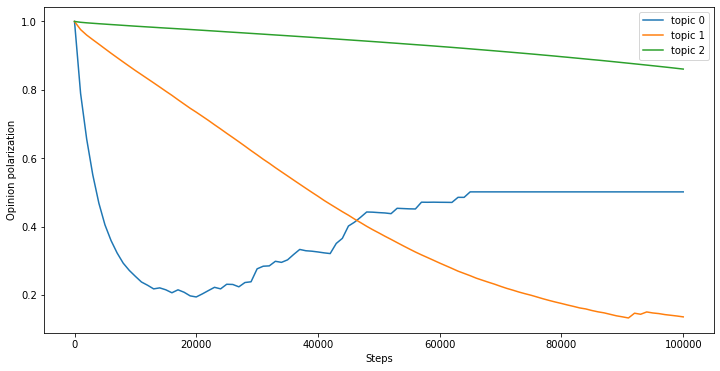

In [9]:
# visulize the polarization values
plt.figure(figsize = (12, 6))
for i in range(sim.get_num_opinion()):
  plt.plot(np.array(range(len(final_concensus)))*1000, np.array(final_concensus).T[i], label = "topic " + str(i))
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Opinion polarization")
plt.show()

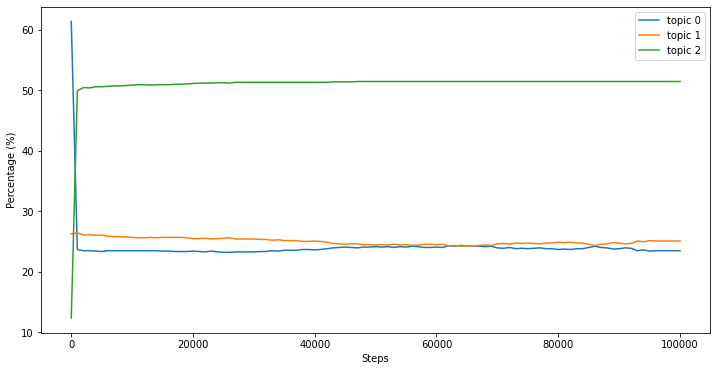

In [10]:
# visulize the preferred topic
plt.figure(figsize = (12, 6))
for i in range(sim.get_num_opinion()):
  plt.plot(np.array(range(len(final_concensus)))*1000, np.array(final_topic).T[i], label = "topic " + str(i))
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Percentage (%)")
plt.show()

### **Local Analysis for 2 nodes**

In [0]:
# local simulation function
def LocalSimulation(opinion_diff, weight = 1, num_opinion = 3, alpha = 0.07, beta = 0.3, gamma = 4):
  track_opinion = [opinion_diff]
  track_weight = [weight] 
  for i in range(1000):
    # these formula are in the analysis pdf: measuring the changes in the next opinion and weight basd on current values
    track_opinion.append(abs(track_opinion[-1] * (1-2*alpha*track_weight[-1])))
    track_weight.append(track_weight[-1] + beta*track_weight[-1]*(1-track_weight[-1])*(1-gamma*track_opinion[-1]))
  return track_opinion, track_weight


In [0]:
def vector_field(alpha=0.03, beta=0.3, gamma=4, plot_option = True, multi_plot = False):
  #2D Vector field plots
  # Create grid coordinates
  opp_diff = np.linspace(0, 1, 11)
  edge_weight = np.linspace(0, 1, 11)
  opp_diff_grid, edge_weight_grid = np.meshgrid(opp_diff, edge_weight)
  if plot_option and not multi_plot:
    plt.figure(figsize=(8, 8))
  # Compute vector field
  vector_x = abs(1-2*alpha*edge_weight_grid)*opp_diff_grid - opp_diff_grid
  vector_y = beta*edge_weight_grid*(1-edge_weight_grid)*(1-gamma*opp_diff_grid)
  converge, diverge, other = 0, 0, 0
  for a in opp_diff:
    for b in edge_weight:
      x_axis, y_axis = LocalSimulation(a, b, alpha = alpha, beta = beta, gamma = gamma)
    
      if y_axis[-1] < 0.05:
        if plot_option:
          plt.plot(x_axis, y_axis, color = "red")
        diverge += 1
      elif y_axis[-1] > 0.95:
        if plot_option:
          plt.plot(x_axis, y_axis, color = "green")
        converge += 1
      else:
        if plot_option:
          plt.plot(x_axis, y_axis, color = "blue")
        other += 1
  # Plot vector field
  if plot_option:
    plt.quiver(opp_diff_grid, edge_weight_grid, vector_x, vector_y, scale=0.5)
    plt.title('alpha: {}, beta: {}, gamma: {}'.format(alpha, beta, gamma))
    plt.xlabel('opinion difference')
    plt.ylabel('weight')
    plt.show()
  else:
    return converge/np.sum([converge, diverge, other]), diverge/np.sum([converge, diverge, other])

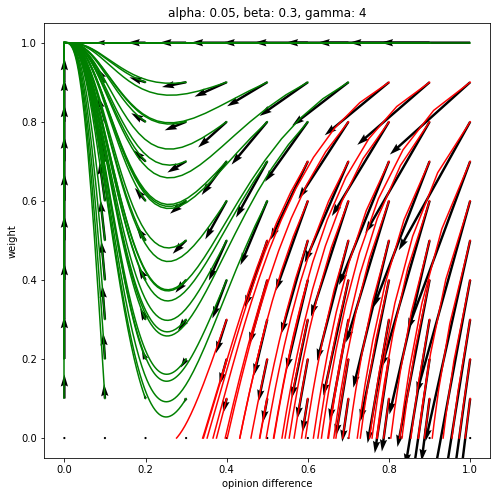

In [13]:
vector_field(alpha = 0.05, beta = 0.3, gamma = 4, plot_option=1)

### **Contour plot for local analysis**

In [0]:
# initlize some values for alpha, beta, gamma
points = 11
a = np.linspace(0, 0.5, points)
b = np.linspace(0, 1, points)
g = np.linspace(0, 5, points)

In [0]:
#visulize the contour plot of these parameters with the function value is the convergence rate
def contour(points, alpha = [0], beta = [0], gamma = [0]):
  a, b, g = alpha, beta, gamma
  if sum(g) == 0:
    a, b = a, b
  elif sum(b) == 0:
    a, b = a, g
  elif sum(a) == 0:
    a, b = b, g
  
  # shape for contour plot
  a, b = np.meshgrid(a, b)
  a, b = a.flatten(), b.flatten()
  track_converge = []
  track_diverge = []
  for i in range(points**2):
    val_1, val_2 = a[i], b[i]
    # simulate LocalAnalysis to find the convergence rate
    if sum(gamma) == 0:
      c1, d1 = vector_field(alpha = val_1, beta = val_2, plot_option=0)
    elif sum(beta) == 0:
      c1, d1 = vector_field(alpha = val_1, gamma = val_2, plot_option=0)
    elif sum(alpha) == 0:
      c1, d1 = vector_field(beta = val_1, gamma = val_2, plot_option=0)
    track_converge.append(c1)
    track_diverge.append(d1)
  
  # outcome
  Z = np.array(track_converge).reshape(points, points)
  plt.figure(figsize = (12, 8))
  plt.contour(a.reshape(points, points), b.reshape(points, points), np.array(track_converge).reshape(points, points), 20, cmap='inferno')
  plt.colorbar()

  # labels
  if sum(gamma) == 0:
    plt.xlabel("alpha")
    plt.ylabel("beta")
    plt.title("alpha-beta relationship to local percentage of converging")
  elif sum(beta) == 0:
    plt.xlabel("alpha")
    plt.ylabel("gamma")
    plt.title("alpha-gamma relationship to local percentage of converging")
  elif sum(alpha) == 0:
    plt.xlabel("beta")
    plt.ylabel("gamma")
    plt.title("beta-gamma relationship to local percentage of converging") 

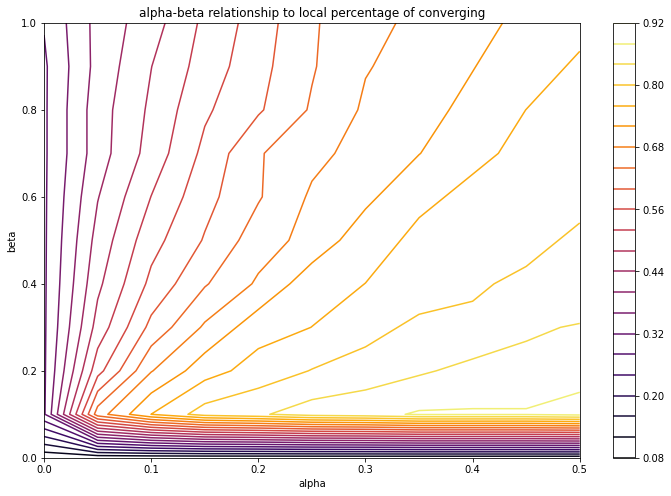

In [16]:
# visualize the plot with alpha-beta parameters
contour(points, alpha = a, beta = b)

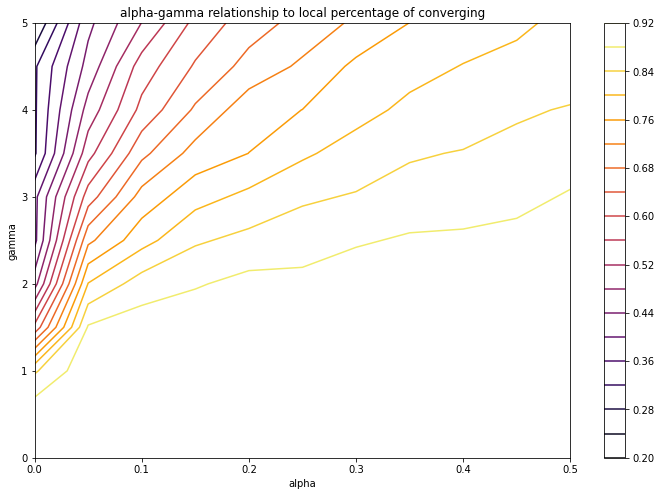

In [17]:
# visualize the plot with alpha-gamma parameters
contour(points, alpha = a, gamma = g)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  


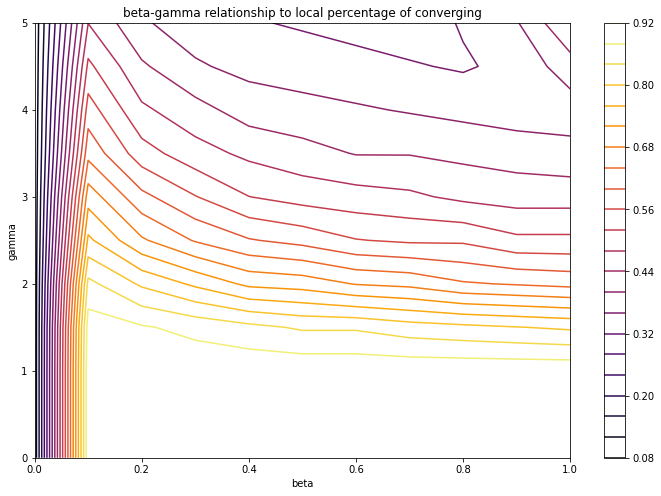

In [18]:
# visualize the plot with beta-gamma parameters
contour(points, beta = b, gamma = g)